# **Parkinson Severity Classification: Inner Evaluation 5**

> **Finding the optimal Multi Layer Perceptron using *standard scaler* as preprocessing technique for the predictors matrices obtained through the top 5 features extraction method that were selected in the round two of the inner evaluation.**

> **The main point is to analyze if standardizing the data helps to improve the MLP performance, since up to now is the best model, and this kind of model usually work better with scaled input data**

## **Requirements**

In [5]:
import numpy  as np
import polars as pl
import sys
import pickle
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.model_selection import train_test_split, StratifiedKFold
from itertools import combinations
from skorch import NeuralNetClassifier
import torch
from sklearn.pipeline import Pipeline, FunctionTransformer


In [6]:
sys.path.insert(0, r'C:\Users\fscielzo\Documents\Packages\PyDL_Package_Private')
from PyDL.models import SimpleClassifier, AdvancedClassifier

In [7]:
sys.path.insert(0, r'C:\Users\fscielzo\Documents\Packages\PyML_Package_Private')
from PyML.evaluation import SimpleEvaluation
from PyML.transformers import scaler

In [8]:
sys.path.insert(0, r'C:\Users\fscielzo\Documents\Packages\PyAudio_Package_Private')
from PyAudio import get_X_audio_features

In [11]:
with open(f'results/top_methods_2', 'rb') as file:
        top_methods = pickle.load(file)

with open(f'results/top_stats_2', 'rb') as file:
        top_stats = pickle.load(file)

## **Data definition**

In this section we define the data to be used. Specifically we define the response variable and a set of predictors matrices to be used as different alternatives, each one associate to a combination of features extraction methods and statistics.

In [12]:
files_list_name = 'Files_List.txt'
files_df = pl.read_csv(files_list_name, separator='\t', has_header=False, new_columns=['path', 'level'])

In [13]:
fs = 16000 # Sampling frequency
wst = 0.032 # Window size (seconds)
fpt = 0.008 # Frame period (seconds)
nfft = int(np.ceil(wst*fs)) # Window size (samples)
fp = int(np.ceil(fpt*fs)) # Frame period (samples)
nbands = 40 # Number of filters in the filterbank
ncomp = 20 # Number of MFCC components

In [14]:
Y = files_df['level'].to_numpy()

simple_methods = ['MFCC', 'spectral_centroid', 'chroma', 'spectral_bandwidth', 
                  'spectral_contrast', 'spectral_rolloff', 'zero_crossing_rate', 'tempogram']

combined_methods = []

stats = ['mean-std', 'median-std', 'mean-median-std', 'mean-Q25-median-Q75-std']

sizes = range(2, len(simple_methods) + 1)

combined_methods = ['-'.join(sorted(combi)) for size in sizes for combi in combinations(simple_methods, size)]

X_stats, X_stats_train, X_stats_test = {method: {} for method in simple_methods + combined_methods}, {method: {} for method in simple_methods + combined_methods}, {method: {} for method in simple_methods + combined_methods}

for method in simple_methods:
    for stat in stats:

        X_stats[method][stat] = get_X_audio_features(paths=files_df['path'], method=method, stats=stat, sr=fs, n_fft=nfft, hop_length=fp, n_mels=nbands, n_mfcc=ncomp)

for method in combined_methods:
    for stat in stats:

        X_stats[method][stat] = np.column_stack([X_stats[method.split('-')[i]][stat] for i in range(0, len(method.split('-')))])

## **Pipelines**

Here we define a pipeline that incorporates an standard scaler as transformer (preprocessing method) and MLP as estimator (model).

In [26]:
MLP_pipeline = Pipeline([
    ('scaler', scaler(apply=True, method='standard')),
    ('MLP', MLPClassifier(random_state=123)),
])

## **Outer validation method: train-test split**

We split our data (response and predictors) in two partitions, the training and the testing one. The training partition will be used in the inner evaluation for selecting the best approach to predict the PD level, and the test one will only be used at the very end for making an estimation of the future performance of the best approach, that is, and estimation of how this approach will classify the level of PD of new patients.

In [16]:
for method in simple_methods + combined_methods:
    for stat in stats:
        X_stats_train[method][stat], X_stats_test[method][stat], Y_train, Y_test = train_test_split(X_stats[method][stat], Y, test_size=0.25, random_state=123, stratify=Y)

## **Applying Inner Evaluation**

In this section we are going to apply the round three of the inner evaluation.

### **Inner validation method: KFold Cross Validation**

We define the validation method to be used in the inner evaluation, that will be Stratified KFold Cross Validation.

In [17]:
inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

We define dictionaries to save important results that will be gathered in the inner evaluation.

In [25]:
inner_score, best_params, inner_results = {method: {stat: {} for stat in stats} for method in simple_methods + combined_methods}, {method: {stat: {} for stat in stats} for method in simple_methods + combined_methods}, {method: {stat: {} for stat in stats} for method in simple_methods + combined_methods}

### **Grids for HPO** 

#### Grid for Multi Layer Perceptron

In [27]:
# Grid for Multi-Layer Perceptron
def param_grid_MLP(trial):

    param_grid = ({
        # preprocessing grid
        'scaler__method': trial.suggest_categorical('scaler__method', ['standard']), # 'min-max' seems to work badly
        # model grid
        'MLP__learning_rate_init': trial.suggest_float('MLP__learning_rate_init', 0.0001, 0.01, log=True),
        'MLP__alpha': trial.suggest_float('MLP__alpha', 0.001, 0.3, log=True),
        'MLP__activation': trial.suggest_categorical('MLP__activation', ['logistic']),
        'MLP__hidden_layer_sizes': trial.suggest_categorical('MLP__hidden_layer_sizes', [80, 100, 130, 150, 180, 200, 250, 300, 350, 400]),
        'MLP__max_iter': trial.suggest_categorical('MLP__max_iter', [100, 130, 150, 180, 200, 250, 300, 350, 400, 450, 500, 550])
    })

    return param_grid

### **HPO**

We are going to apply HPO over MLP for the **top 5** feature extraction methods according to the **round 2 inner evaluation**, as we did in round 3, but now **standardizing** the input data.

#### HPO for Multi Layer Perceptron

In [ ]:
model = 'MLP_scaled'

simple_eval = SimpleEvaluation(estimator=MLP_pipeline, param_grid=param_grid_MLP, 
                 inner=inner, search_method='optuna', scoring='balanced_accuracy', direction='maximize', 
                 n_trials=250, random_state=123)

for method, stat in zip(top_methods, top_stats):

    print('-------------------------------------------------------------------------------')
    print(method, stat, model)
    print('-------------------------------------------------------------------------------')

    simple_eval.fit(X=X_stats_train[method][stat], Y=Y_train)
    inner_score[method][stat][model] = simple_eval.inner_score
    best_params[method][stat][model]= simple_eval.inner_best_params
    inner_results[method][stat][model] = simple_eval.inner_results

#### Saving the results

In [29]:
'''
with open('results/best_params_5', 'wb') as file:
    pickle.dump(best_params, file)

with open('results/inner_scores_5', 'wb') as file:
    pickle.dump(inner_score, file)

with open('results/inner_results_5', 'wb') as file:
    pickle.dump(inner_results, file)
'''

#### Opening the results

In [30]:
with open(f'results/best_params_5', 'rb') as file:
        best_params = pickle.load(file)

with open(f'results/inner_scores_5', 'rb') as file:
        inner_score = pickle.load(file)

with open(f'results/inner_results_5', 'rb') as file:
        inner_results = pickle.load(file)

### **Selecting the best pipeline**

In this section we are going to select the best pipeline, that is, the best combination of preprocessing techniques and model, in this case the feature extraction methods are the preprocessing techniques.

All the alternatives evaluated are ranked according to their inner scores (balanced accuracy), and   summarized in a plot.

In [31]:
inner_score_flatten = {key1 + '__' + key2 + '__' + key3 : inner_score[key1][key2][key3]  
                       for key1 in inner_score.keys() 
                       for key2 in inner_score[key1].keys() 
                       for key3 in inner_score[key1][key2].keys()}
best_params_flatten = {key1 + '__' + key2 + '__' + key3 : best_params[key1][key2][key3]  
                       for key1 in best_params.keys() 
                       for key2 in best_params[key1].keys() 
                       for key3 in best_params[key1][key2].keys()}
inner_results_flatten = {key1 + '__' + key2 + '__' + key3 : inner_results[key1][key2][key3]  
                        for key1 in inner_results.keys() 
                        for key2 in inner_results[key1].keys() 
                        for key3 in inner_results[key1][key2].keys()}

inner_score_values = np.array(list(inner_score_flatten.values()))
pipelines_names = np.array(list(inner_score_flatten.keys()))
best_pipeline = pipelines_names[np.argmax(inner_score_values)]
score_best_pipeline = np.max(inner_score_values)

combined_models_score = list(zip(pipelines_names, inner_score_values))
sorted_combined_models_score= sorted(combined_models_score, key=lambda x: x[1], reverse=True)  # Sort from greater to lower
sorted_pipelines, sorted_scores = zip(*sorted_combined_models_score)
sorted_pipelines = list(sorted_pipelines)
sorted_scores = list(sorted_scores)

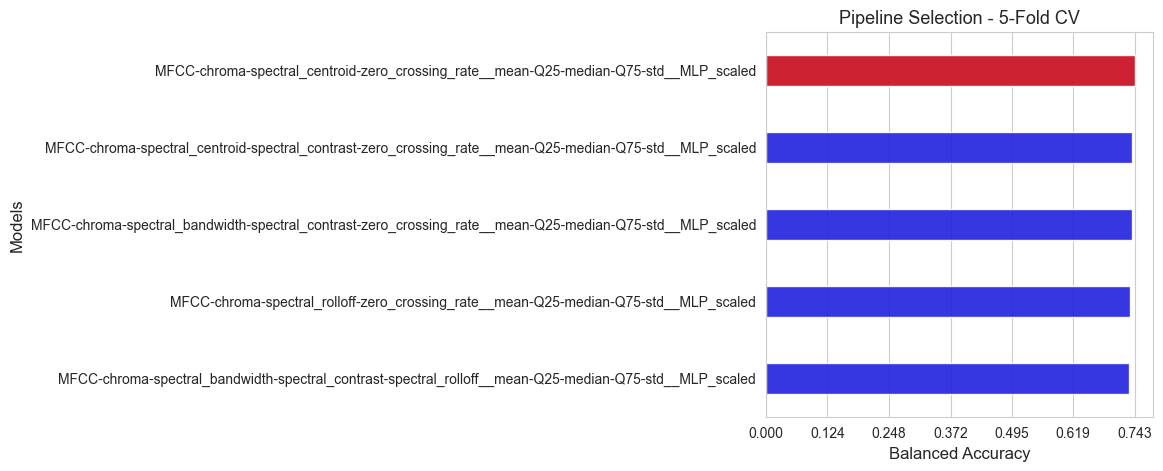

The best pipeline according to the inner evaluation is: MFCC-chroma-spectral_centroid-zero_crossing_rate__mean-Q25-median-Q75-std__MLP_scaled
Balanced accuracy of the best pipeline:  0.743

 Best feature extraction method:  MFCC-chroma-spectral_centroid-zero_crossing_rate 
 Best stats:  mean-Q25-median-Q75-std 
 Best model:  MLP_scaled

The best model hyper-parameters are:  {'scaler__method': 'standard', 'MLP__learning_rate_init': 0.007698005277655154, 'MLP__alpha': 0.0014043387552593086, 'MLP__activation': 'logistic', 'MLP__hidden_layer_sizes': 100, 'MLP__max_iter': 300}


In [32]:
fig, axes = plt.subplots(figsize=(5,5))

ax = sns.barplot(y=sorted_pipelines, x=sorted_scores, color='blue', width=0.4, alpha=0.9)
ax = sns.barplot(y=[best_pipeline], x=[score_best_pipeline], color='red', width=0.4, alpha=0.9)

ax.set_ylabel('Models', size=12)
ax.set_xlabel('Balanced Accuracy', size=12)
ax.set_xticks(np.round(np.linspace(0, np.max(inner_score_values), 7),3)) 
ax.tick_params(axis='y', labelsize=10)    
plt.title(f'Pipeline Selection - 5-Fold CV', size=13)
plt.show()

print(f'The best pipeline according to the inner evaluation is: {best_pipeline}')
print('Balanced accuracy of the best pipeline: ', np.round(score_best_pipeline, 3))
best_method = best_pipeline.split('__')[0]
best_stats = best_pipeline.split('__')[1]
best_model = best_pipeline.split('__')[2]
print('\n Best feature extraction method: ', best_method, '\n', 'Best stats: ', best_stats, '\n', 'Best model: ', best_model)

print('\nThe best model hyper-parameters are: ', best_params_flatten[best_pipeline])

As we can see that MLP doesn't work better standardizing the input data, at least in this case. 